In [1]:
#Transformer model 
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import pandas as pd 
import os
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt 
import math
import torch.optim as optim
from nilearn import plotting
from mne.viz import circular_layout
from mne_connectivity.viz import plot_connectivity_circle

In [2]:
torch.manual_seed(2351564) #CID

#Parallelizing 
num_threads = torch.get_num_threads()
# Set the number of threads to the maximum available
torch.set_num_threads(num_threads)

In [3]:
#Hyperparameters for the depression dataset: 
embed_dim = 166
time_length = 196
batch_size = 32

In [4]:
#Execute data loading in Pytorch loaders 
filename = 'cocaine_data_loading.py'
with open(filename, 'r') as file:
    script_content = file.read()
exec(script_content)

0it [00:00, ?it/s]

140it [00:57,  2.45it/s]
  0%|          | 0/123 [00:00<?, ?it/s]/home/ma/s/sk4722/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 123/123 [00:02<00:00, 45.79it/s]
/home/ma/s/sk4722/.local/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [23]:
# Create boolean masks for each label
mask_HC = labels == 0
mask_CUD = labels == 1

# Create tensors for each label by indexing with the boolean masks
BOLD_HC = BOLD_signals[mask_HC]
BOLD_CUD = BOLD_signals[mask_CUD]

# Exploratory data analysis

In [25]:
#Retrieve atlas information

rois = pd.read_table('AAL3/ROI_MNI_V7_vol.txt', sep = '\t')

#Reorder to match the order of the atlas

n = rois.shape[0]
even_indices = list(range(0, n, 2))
odd_indices = list(range(1, n, 2))
new_order = even_indices + odd_indices[::-1]

rois = rois.iloc[new_order]
rois.reset_index(drop=True, inplace=True)

extract_group = lambda x: x[:3] if len(x) >= 3 else x

rois['Group'] = rois['nom_l'].apply(extract_group)

In [26]:
import hashlib

def string_to_distinct_rgb(s):
    if len(s) != 3:
        raise ValueError("The string must contain exactly 3 letters.")
    # Generate a hash of the string
    m = hashlib.md5()
    m.update(s.encode('utf-8'))
    digest = m.digest()
    
    # Use the first 3 bytes of the hash as RGB values
    return tuple(digest[i]/255 for i in range(3))


rois['color'] = rois['Group'].apply(string_to_distinct_rgb)

In [27]:
mean_bold_HC = np.mean(BOLD_HC, axis = 0).T
mean_bold_CUD = np.mean(BOLD_CUD, axis = 0).T

In [28]:
def pearson_correlation_matrix(X):
    # Standardize the columns
    Z = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # Calculate the Pearson correlation matrix
    R = np.matmul(Z.T,Z) / (X.shape[0])
    return R

def fisher_z_transformation_matrix(R):
    # Apply Fisher's Z-transformation to each element of the matrix
    Z = 0.5 * np.log((1 + R) / (1 - R))
    return Z

R_bold_HC = pearson_correlation_matrix(mean_bold_HC)
R_bold_CUD = pearson_correlation_matrix(mean_bold_CUD)


np.fill_diagonal(R_bold_HC, 0)
np.fill_diagonal(R_bold_CUD, 0)


Z_bold_HC = fisher_z_transformation_matrix(R_bold_HC)
Z_bold_CUD = fisher_z_transformation_matrix(R_bold_CUD)

/home/ma/s/sk4722/.local/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [29]:
from matplotlib.colors import LinearSegmentedColormap

c_dict = {'red':   [(0.0,  0.0, 0.0),  # Bleu pour les valeurs < 0
                    (0.5,  0.99, 0.99),  # Blanc pour la valeur 0
                    (1.0,  180/255, 180/255)],  # Rouge pour les valeurs > 0

          'green': [(0.0,  0.0, 0.0),  # Bleu
                    (0.5,  0.99, 0.99),  # Blanc
                    (1.0,  0.0, 0.0)],  # Rouge

          'blue':  [(0.0,  180/255, 180/255),  # Bleu
                    (0.5,  0.99, 0.99),  # Blanc
                    (1.0,  0.0, 0.0)]  # Rouge
        }

# Création de la colormap personnalisée
custom_map = LinearSegmentedColormap('BlueWhiteRed', c_dict)

# colors = [(0, 0,180/255),
#           (0.99, 0.99, 0.99), 
#           (180/255, 0,0)]  # Grey to Red
# n_bins = 16 # Discretizes the colormap into these many bins
# cmap_name = "GrRd"
# custom_map = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

In [30]:
Z_bold_HC_filtered = np.where(abs(Z_bold_HC) > 0.65, Z_bold_HC, 0)
Z_bold_CUD_filtered = np.where(abs(Z_bold_CUD) > 0.65, Z_bold_CUD, 0)

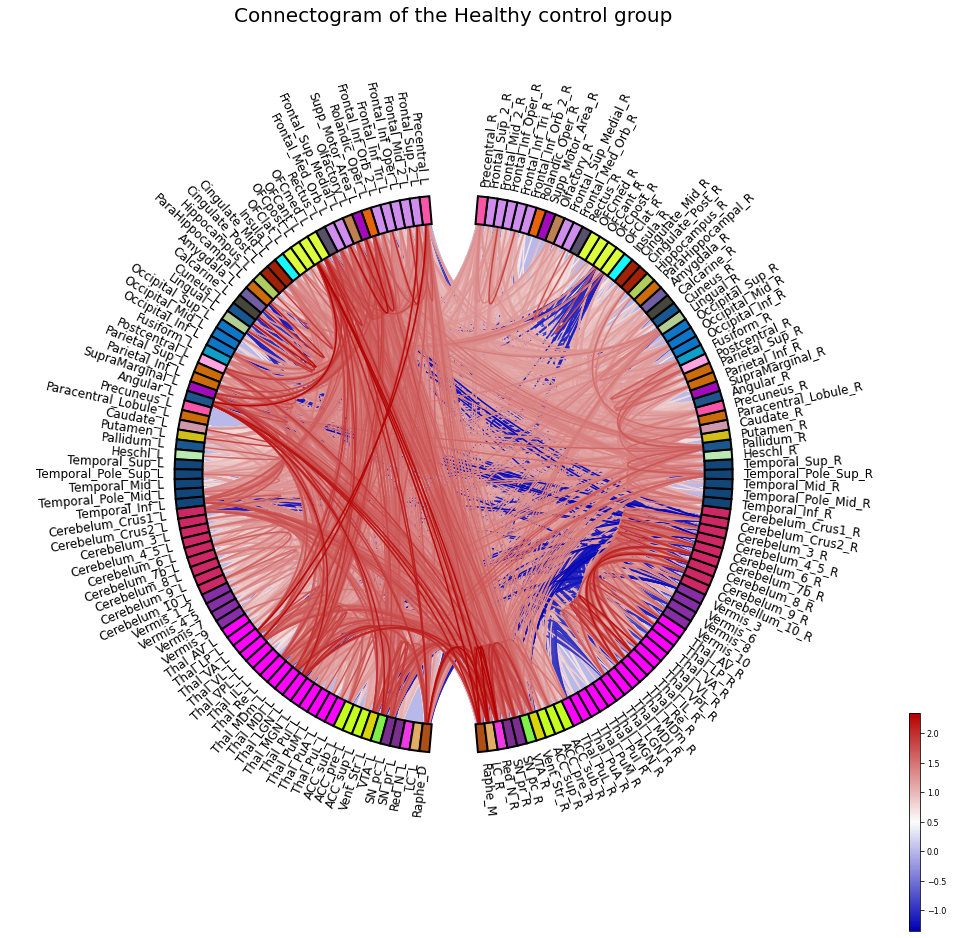

In [31]:
node_angles = circular_layout(
    new_order, new_order, start_pos=90, group_boundaries=[0, len(rois['nom_l']) / 2])

fig, ax = plt.subplots(
    figsize=(20, 20), facecolor="white", subplot_kw=dict(projection="polar"))

plot_connectivity_circle(
    Z_bold_HC_filtered,
    rois['nom_l'],
    #n_lines= (np.abs(Z_bold_depressed)>0.65).sum(),
    node_angles=node_angles,
    node_colors=rois['color'],
    title="Connectogram of the Healthy control group",
    ax=ax,
    facecolor='none',
    textcolor='black',
    fontsize_title=20,
    fontsize_names=12,
    #padding=6,
    #colorbar_size=0.2,
    #vmin=-0.5,
    #vmax=0.5,
    colormap=custom_map
)

#save figure 
fig.savefig('figures/cocaine/connectogram_HC.png', 
            facecolor=fig.get_facecolor(), 
            edgecolor='none', 
            bbox_inches='tight')

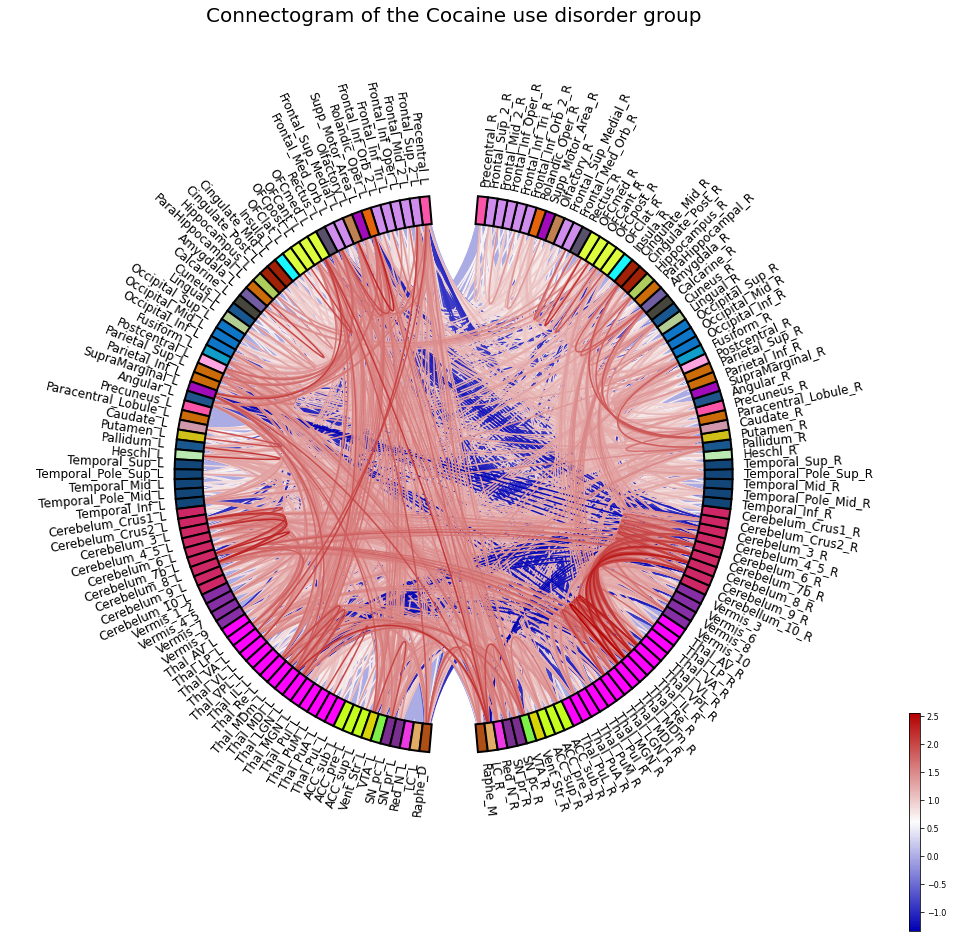

In [32]:
node_angles = circular_layout(
    new_order, new_order, start_pos=90, group_boundaries=[0, len(rois['nom_l']) / 2])

fig, ax = plt.subplots(
    figsize=(20, 20), facecolor="white", subplot_kw=dict(projection="polar"))

plot_connectivity_circle(
    Z_bold_CUD_filtered,
    rois['nom_l'],
    #n_lines= (np.abs(Z_bold_depressed)>0.65).sum(),
    node_angles=node_angles,
    node_colors=rois['color'],
    title="Connectogram of the Cocaine use disorder group",
    ax=ax,
    facecolor='none',
    textcolor='black',
    fontsize_title=20,
    fontsize_names=12,
    #padding=6,
    #colorbar_size=0.2,
    #vmin=-0.5,
    #vmax=0.5,
    colormap=custom_map
)

#save figure 
fig.savefig('figures/cocaine/connectogram_CUD.png', 
            facecolor=fig.get_facecolor(), 
            edgecolor='none', 
            bbox_inches='tight')

In [17]:
Z_bold_HC_filtered.shape

(166, 166)

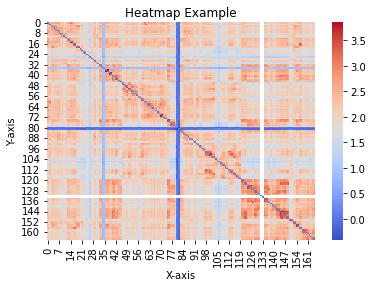

In [14]:
import numpy as np  # NumPy for numerical operations
import seaborn as sns  # Seaborn for plotting
import matplotlib.pyplot as plt  # Matplotlib for additional customization

# Create a heatmap using Seaborn
# annot=True displays the values inside the cells
# cmap specifies the color map
sns.heatmap(Z_bold_healthy_male, annot=False, cmap='coolwarm')

# Show additional customization options using Matplotlib
plt.title('Heatmap Example')  # Set the title
plt.xlabel('X-axis')  # Set the x-axis label
plt.ylabel('Y-axis')  # Set the y-axis label

# Show the plot
plt.show()


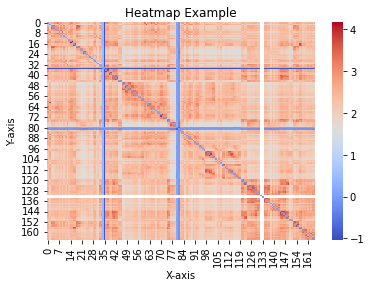

In [15]:
import numpy as np  # NumPy for numerical operations
import seaborn as sns  # Seaborn for plotting
import matplotlib.pyplot as plt  # Matplotlib for additional customization

# Create a heatmap using Seaborn
# annot=True displays the values inside the cells
# cmap specifies the color map
sns.heatmap(Z_bold_healthy_female, annot=False, cmap='coolwarm')

# Show additional customization options using Matplotlib
plt.title('Heatmap Example')  # Set the title
plt.xlabel('X-axis')  # Set the x-axis label
plt.ylabel('Y-axis')  # Set the y-axis label

# Show the plot
plt.show()


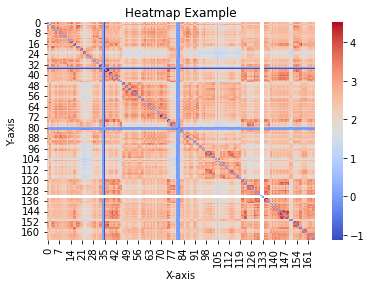

In [16]:
import numpy as np  # NumPy for numerical operations
import seaborn as sns  # Seaborn for plotting
import matplotlib.pyplot as plt  # Matplotlib for additional customization

# Create a heatmap using Seaborn
# annot=True displays the values inside the cells
# cmap specifies the color map
sns.heatmap(Z_bold_depressed_male, annot=False, cmap='coolwarm')

# Show additional customization options using Matplotlib
plt.title('Heatmap Example')  # Set the title
plt.xlabel('X-axis')  # Set the x-axis label
plt.ylabel('Y-axis')  # Set the y-axis label

# Show the plot
plt.show()


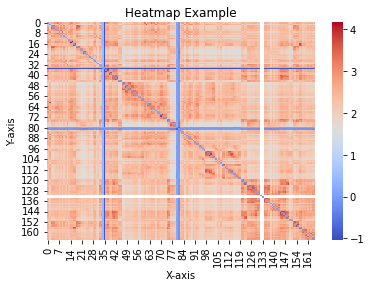

In [17]:
import numpy as np  # NumPy for numerical operations
import seaborn as sns  # Seaborn for plotting
import matplotlib.pyplot as plt  # Matplotlib for additional customization

# Create a heatmap using Seaborn
# annot=True displays the values inside the cells
# cmap specifies the color map
sns.heatmap(Z_bold_healthy_female, annot=False, cmap='coolwarm')

# Show additional customization options using Matplotlib
plt.title('Heatmap Example')  # Set the title
plt.xlabel('X-axis')  # Set the x-axis label
plt.ylabel('Y-axis')  # Set the y-axis label

# Show the plot
plt.show()
